<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/UCI_HAR_SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Add ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy

In [22]:

# 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:


LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]



In [24]:
# 데이터 로드 (X_train, X_test가 정의되지 않은 경우를 대비)
if 'X_train' not in locals() or 'X_test' not in locals():
    TRAIN = "train/"
    TEST = "test/"
    DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

    INPUT_SIGNAL_TYPES = [
        "body_acc_x_",
        "body_acc_y_",
        "body_acc_z_",
        "body_gyro_x_",
        "body_gyro_y_",
        "body_gyro_z_",
        "total_acc_x_",
        "total_acc_y_",
        "total_acc_z_"
    ]

    def load_X(X_signals_paths):
        X_signals = []
        for signal_type_path in X_signals_paths:
            series_list = []
            with open(signal_type_path, 'r') as file:
                for row in file:
                    row_clean = row.replace('  ', ' ')
                    row_clean = row_clean.strip()
                    serie = row_clean.split(' ')
                    serie_array = np.array(serie, dtype=np.float32)
                    series_list.append(serie_array)
            X_signals.append(series_list)
        X_signals = np.array(X_signals)
        return np.transpose(X_signals, (1, 2, 0))

    X_train_signals_paths = [
        DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
        for signal in INPUT_SIGNAL_TYPES
    ]
    X_test_signals_paths = [
        DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
        for signal in INPUT_SIGNAL_TYPES
    ]

    X_train = load_X(X_train_signals_paths)
    X_test = load_X(X_test_signals_paths)
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)


input_shape = (X_train.shape[1], X_train.shape[2])  # (시간 스텝, 특성 수)
num_classes = 6  # 6가지 활동 분류

In [25]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_study/UCI HAR Dataset/"

#===데이터 전체 저장===
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # ===형태 변환===
    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("첫 번째 샘플 데이터:\n", X_train[0])

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)
첫 번째 샘플 데이터:
 [[ 1.808515e-04  1.076681e-02  5.556068e-02 ...  1.012817e+00
  -1.232167e-01  1.029341e-01]
 [ 1.013856e-02  6.579480e-03  5.512483e-02 ...  1.022833e+00
  -1.268756e-01  1.056872e-01]
 [ 9.275574e-03  8.928878e-03  4.840473e-02 ...  1.022028e+00
  -1.240037e-01  1.021025e-01]
 ...
 [-1.147484e-03  1.714439e-04  2.647864e-03 ...  1.018445e+00
  -1.240696e-01  1.003852e-01]
 [-2.222655e-04  1.574181e-03  2.381057e-03 ...  1.019372e+00
  -1.227451e-01  9.987355e-02]
 [ 1.575500e-03  3.070189e-03 -2.269757e-03 ...  1.021171e+00
  -1.213260e-01  9.498741e-02]]


In [26]:
# load_y
#텍스트 파일 읽기, 라벨 파싱, 인덱스 조정

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    return np.array(labels, dtype=np.int32) - 1

In [27]:
# Define paths for the training and testing label files
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

# Load the data
y_train = load_y(y_train_path)  # 훈련 데이터 레이블
y_test = load_y(y_test_path)    # 테스트 데이터 레이블

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("첫 번째 훈련 데이터 레이블:", y_train[0])
print("첫 번째 테스트 데이터 레이블:", y_test[0])

y_train shape: (7352,)
y_test shape: (2947,)
첫 번째 훈련 데이터 레이블: 4
첫 번째 테스트 데이터 레이블: 4


In [28]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (시간 스텝, 특성 수)
num_classes = 6  # 6가지 활동 분류


In [29]:


# SENet 블록 정의
def se_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    # Use Keras Reshape layer instead of tf.reshape
    se = tf.keras.layers.Reshape((1, filters))(se)

    return tf.keras.layers.multiply([input_tensor, se])

# Functional API를 사용하여 모델 정의 (Sequential API에서 이전 레이어 출력을 전달하기 어려움)
input_layer = Input(shape=input_shape)

conv1 = Conv1D(64, 5, padding='same')(input_layer)
bn1 = BatchNormalization()(conv1)
relu1 = ReLU()(bn1)
se1 = se_block(relu1, ratio=16) # Pass output of previous layer

conv2 = Conv1D(128, 3, padding='same')(se1)
bn2 = BatchNormalization()(conv2)
relu2 = ReLU()(bn2)
se2 = se_block(relu2, ratio=16) # Pass output of previous layer
pool1 = MaxPooling1D(2)(se2)

conv3 = Conv1D(256, 3, padding='same')(pool1)
bn3 = BatchNormalization()(conv3)
relu3 = ReLU()(bn3)
se3 = se_block(relu3, ratio=16) # Pass output of previous layer

global_avg_pool = GlobalAveragePooling1D()(se3)

dense1 = Dense(128, activation='relu')(global_avg_pool)
dropout1 = Dropout(0.3)(dense1)
output_layer = Dense(num_classes, activation='softmax')(dropout1)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)


# 모델 컴파일
model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
        )

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 128, 64)   │      2,944 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 128, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_6[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4)         │        256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 64)        │        256 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 64)     │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 128, 64)   │          0 │ re_lu_6[0][0],    │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 128, 128)  │     24,704 │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_7 (ReLU)      │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ re_lu_7[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 8)         │      1,024 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │      1,024 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 128)    │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 128, 128)  │          0 │ re_lu_7[0][0],    │
│ (Multiply)          │                   │            │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 64, 128)   │          0 │ multiply_4[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 64, 256)   │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 256)   │      1,024 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 172,422 (673.52 KB)

 Trainable params: 171,526 (670.02 KB)

 Non-trainable params: 896 (3.50 KB)

None


In [31]:
optimizer=Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict=dict(enumerate(class_weights))

early_stop=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
# Add ModelCheckpoint and ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

history=model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Use validation_split instead of validation_data
    class_weight=class_weights_dict,
    callbacks=[early_stop, model_checkpoint, reduce_lr] # Add callbacks
)

Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.1159 - sparse_categorical_accuracy: 0.6301

184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - loss: 1.1141 - sparse_categorical_accuracy: 0.6309 - val_loss: 1.7119 - val_sparse_categorical_accuracy: 0.2712 - learning_rate: 1.0000e-04
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.3429 - sparse_categorical_accuracy: 0.9181

184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.3426 - sparse_categorical_accuracy: 0.9181 - val_loss: 0.6234 - val_sparse_categorical_accuracy: 0.8110 - learning_rate: 1.0000e-04
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1798 - sparse_categorical_accuracy: 0.9435

184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 0.1798 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.3130 - val_sparse_categorical_accuracy: 0.9041 - learning_rate: 1.0000e-04
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.1375 - sparse_categorical_accuracy: 0.9485 - val_loss: 0.3669 - val_sparse_categorical_accuracy: 0.9041 - learning_rate: 1.0000e-04
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.1195 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.3917 - val_sparse_categorical_accuracy: 0.8960 - learning_rate: 1.0000e-04
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9494 - val_loss: 0.4101 - val_sparse_categorical_accuracy: 0.9109 - learning_rate: 1.0000e-04
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.4293 - val_sparse_categorical_accuracy: 0.9109 - learning_rate: 1.0000e-04
Epoch 8/50
184/184 ━━━━━━━━━━━━

In [36]:
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 8))

    plt.plot(epoch_range, history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.figure(figsize=(12, 8))
    plt.plot(epoch_range, history.history['loss'], label='Training Loss')
    plt.plot(epoch_range, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

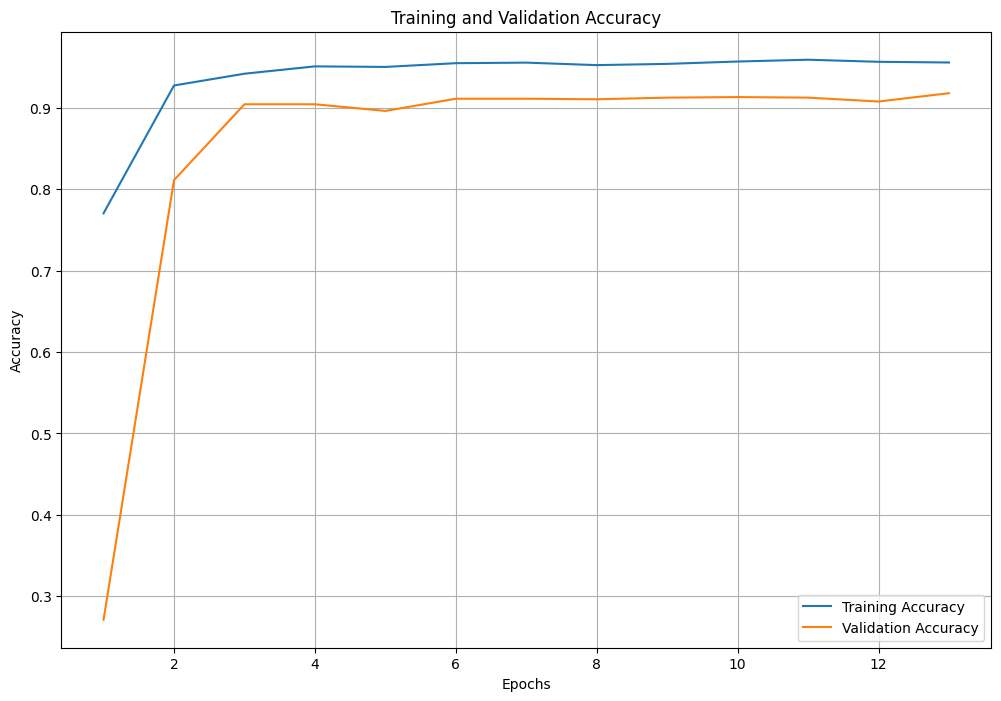

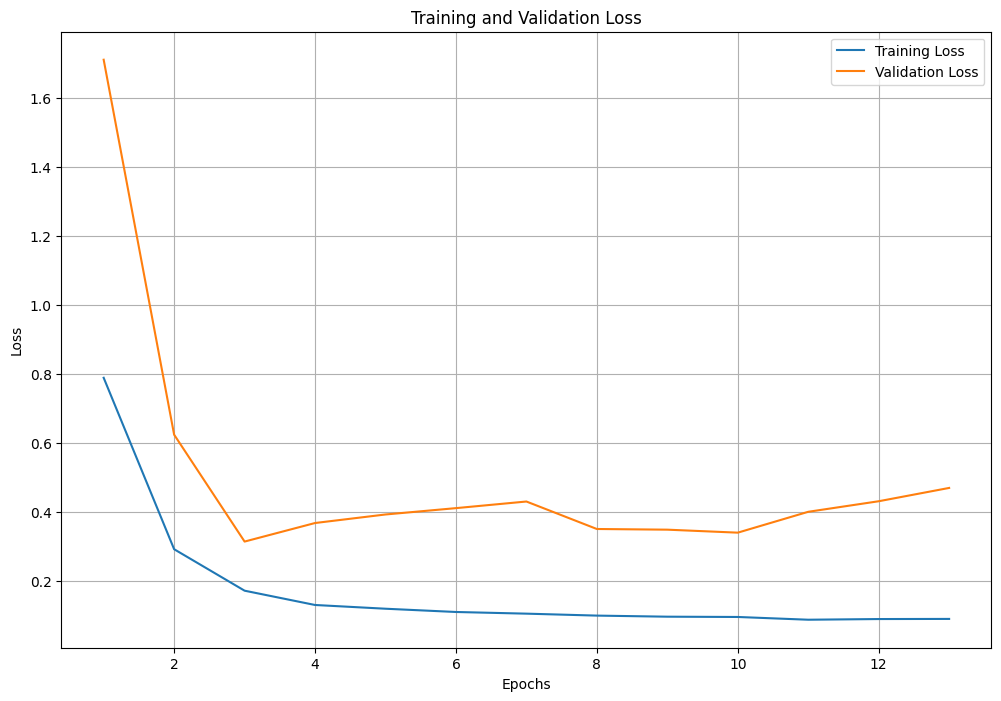

In [37]:
plot_learningCurve(history, len(history.history['loss']))

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3402 - sparse_categorical_accuracy: 0.8789
Test Loss: 0.2667
Test Accuracy: 0.9186
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

Classification Report:
                    precision    recall  f1-score   support

           WALKING       1.00      0.95      0.98       496
  WALKING_UPSTAIRS       0.93      0.94      0.94       471
WALKING_DOWNSTAIRS       0.89      1.00      0.94       420
           SITTING       0.83      0.83      0.83       491
          STANDING       0.86      0.85      0.85       532
            LAYING       1.00      0.96      0.98       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947


Confusion Matrix:


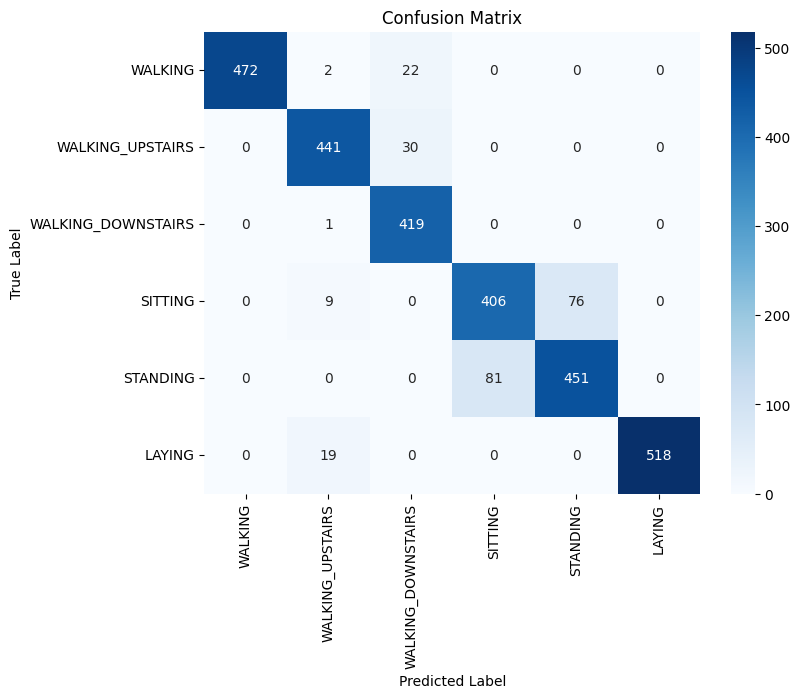

In [38]:
# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# 분류 리포트 및 혼동 행렬
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=LABELS))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [40]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.9186
테스트 데이터 손실 (Loss): 0.2667
